<a href="https://colab.research.google.com/github/lanceaquino/CS146/blob/main/CS146_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS146 Assignmnent 3: Using Stan and other excercises # 

## Implement Models in Stan ## 



###1.  Call Center Data Set - Exponential Likelihood with a Gamma Prior ###

In [1]:
import numpy as np
import pystan
import pandas as pd
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("https://course-resources.minerva.kgi.edu/uploaded_files/mke/00124343-8397/call-center.csv", header = None)
waiting_times_day = df.to_numpy()

In [4]:
# Make 24 empty lists, one per hour.
waiting_times_per_hour = [[] for _ in range(24)]

# Split the data into 24 separate series, one for each hour of the day.
current_time = 0
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(float(t))

#### Check Data Structure for Hour 13#### 

Size of data set: 5856
First 3 values in data set: [[30. ]
 [ 3.4]
 [ 3.2]]
Sum of data set: [1441.68381538]


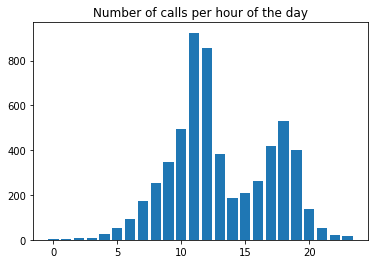

In [5]:
print('Size of data set:', len(waiting_times_day))
print('First 3 values in data set:', waiting_times_day[:3])
print('Sum of data set:', sum(waiting_times_day))

plt.bar(range(24), [len(w) for w in waiting_times_per_hour])
plt.title('Number of calls per hour of the day')
plt.show()

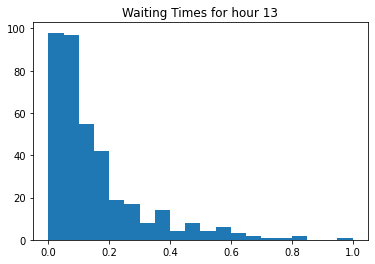

In [6]:
# We only want to look into the 13th hour 
hour_index = 13
waiting_times_hour = waiting_times_per_hour[hour_index]

plt.hist(waiting_times_hour, bins = 20)
plt.title(f"Waiting Times for hour {hour_index}")
plt.show()

#### Create Stan Data and Model #### 

In [7]:
# Here, we provide stan our known quantities of the call center data set. 
# This includes our known quantities and hyperparameters. 

call_center_data = {
    'waiting_times' : waiting_times_hour,
    'num_waiting_times': len(waiting_times_hour),
    # Parametrs for the Prior Gamma Distribution 
    'alpha': 1,  # We set alpha to 1 as it makes the gamma distribution follow the an exponential pattern 
    'beta': 0.25,
    
    # # Posterior Gamma Hyperparameters 
    # 'alpha_post': 1 + len(waiting_times_hour),
    # 'beta_post': 0.25 + sum(waiting_times_hour),
}

In [8]:
# Here, we create the instructions for Stan about the model we would like to create 

stan_code_Q1 = """

data {
  int<lower = 1> num_waiting_times; 
  real<lower = 0> waiting_times[num_waiting_times];
  real<lower = 0> alpha; 
  real<lower = 0> beta;
}

parameters {
  real<lower = 0> lambda_; 
}

model {
  lambda_ ~ gamma(alpha, beta);  //Prior 

  for (i in 1:num_waiting_times) {
    waiting_times[i] ~ exponential(lambda_); //Likelihood
  }
}

"""

In [9]:
stan_model_Q1 = pystan.StanModel(model_code=stan_code_Q1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_aa2afff6ee22fbbccbbe202cece649d2 NOW.


In [10]:
stan_results_Q1 = stan_model_Q1.sampling(data = call_center_data)

In [11]:
print(stan_results_Q1.stansummary(pars = ['lambda_'], probs = [0.01, 0.5, 0.99]))

# len(posterior_samples['lambda_'])
# print(len(waiting_times_hour))

Inference for Stan model: anon_model_aa2afff6ee22fbbccbbe202cece649d2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd     1%    50%    99%  n_eff   Rhat
lambda_   6.34  9.0e-3   0.33   5.58   6.33    7.1   1333    1.0

Samples were drawn using NUTS at Sat Feb 20 04:47:06 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


#### Posterior $\lambda$ Confidence Interval and its Distribution ####

In [12]:
posterior_samples = stan_results_Q1.extract()

conf_int_98 = np.quantile(posterior_samples['lambda_'], [0.01, 0.99])

print("98% Confidence Interval", conf_int_98)

98% Confidence Interval [5.58249783 7.09728159]


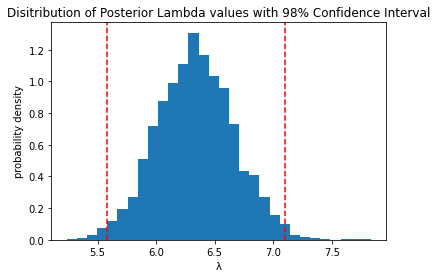

In [49]:
plt.hist(posterior_samples['lambda_'], bins = 30, density = True)
plt.axvline(conf_int_98[0], linestyle = '--', color = 'red')
plt.axvline(conf_int_98[1], linestyle = '--', color = 'red')
plt.title("Disitribution of Posterior Lambda values with 98% Confidence Interval")
plt.xlabel('λ')
plt.ylabel('probability density')
plt.show()

### 2. Normal Likelihood with Normal-inverse Gamma Prior ###

#### Create Data Set #### 

In [16]:
sample_data = np.array([3.54551763569501, 4.23799861761927, 4.72138425951628, -0.692265320368236, 3.04473513808788, 3.10721270732507, 3.42982225852764, 3.12153903971176, 3.60532628639808, 2.46561737557325, 1.64059465916131, 2.4621623937158, 2.76744495617481, 2.11580054750407, 5.14077208608354, 4.90288499104252, 1.43357579078348, 4.78997817363558, 1.93633438207439, 2.43698838097178, 3.95389148701877, 2.4242295507716, 2.90256268679023, 2.90931728045901, 0.658072819386888, 3.05946763895983, 3.42615331539605, 2.68842833004417, 2.35850130765166, 2.20014998540933, 4.73846511350084, 4.19839721414451, 2.11805510171691, -0.572742936038015, 0.389413982010623, 3.87846130744249, 1.34057656890858, 0.7235748351719, 5.11042369840174, 4.00747556696571, 3.18080956726965, 3.24677964069676, 5.1154659863626, 1.80276616697155, 0.305877679021404, -0.449168307882718, 4.63705561194774, 1.37783714058301, 4.9608149859515, 6.7764195802069, 1.75515522922399, 7.04457337435215, 0.625185284955128, 2.25130734369064, 2.19770178119255, 2.16858257249432, 6.25367644481438, 0.116081323476489, 2.06315857864341, 1.82409781471718, 5.15226741230987, 2.03408231293173, -1.12450854337596, 5.03511270642234, 2.03841989653263, 5.80911741751597, 2.31718128783245, 4.97575010580997, 3.34262752222776, -0.786983904253601, 0.777362359850013, 0.975825009321195, 3.76354577515958, 7.27215002907876, 1.35404089480189, 3.76567940257157, 3.48573993343334, 1.85976988586156, 1.93567061960716, 5.31071812003942, 2.96832987672751, 3.32378908637275, 2.61631960054551, 5.80897964052825, 4.95215217171488, 1.32036772796131, 3.79932542233371, 3.08108492766309, 2.6734110081666, -0.14251851138521, 2.48744375588965, 3.98463042123415, 6.32781680028, 4.0029172024315, 4.23210369459457, 1.71412938967325, 5.16492114963802, 2.53409673107906, 4.77346963973334, 3.34088878725551, 4.77681472750664, 3.81135755590976, 1.14054269983137, 1.42057452397702, 0.132142311125433, 7.12577254064672, 4.85422012781764, 4.15745720676399, 4.48763147363348, 1.56060322283629, 2.64821761542887, 1.26655351354548, 4.48497722937931, 4.3286302403783, 4.26157679512625, 4.0597558651364, 5.14051109132496, 2.5660348362221, 1.10764013818617, 0.386889523012303, 3.54150473246237, 3.57480214382351, 1.95150869584847, 2.70688970563118, 2.47971849820016, 6.50838037000679, 4.01511556826974, 1.11562740835344, 5.02637639472439, 4.38184491686864, 5.60423144047386, 2.40067408379298, 5.7849941378344, 2.37225791084559, 6.86031465910273, 4.09214858239736, 6.85994063692621, 3.62202415158781, -1.11220646958158, 3.73920971696866, 3.24533871512216, 1.28724203643002, 0.291152541773164, 0.368630935755111, 6.71607270510525, 5.42278455200833, 5.35188416119281, 2.305874586163, -1.85878097203032, 2.69877382351447, 4.84121860550417, 4.40973060799391, 5.04399320650774, 2.68632252661298, 6.06531610659912, 3.11881325011993, 3.45532087005125, 3.08442259840346, 4.43564424136733, 2.84252623135804, 1.50536798885106, 1.48868622407603, 2.07322837615663, 2.5476910210998, 5.66941808257884, 2.16731067416426, 2.49843958833905, 3.94586413879977, 0.316433764679541, -0.608937441815983, 2.5943436558557, 1.05516869528337, 2.1447601332725, 6.65846634141906, 2.1771555267834, 5.23953812029442, 3.53629759842647, 6.03263538017003, 3.85739159396599, 5.95093453004638, 1.12856987160476, 3.5559912886093, 2.21974864244489, 3.38471394882135, -1.90805399279409, 3.5113699258973, 4.49319955412346, 5.10507952638867, 1.08277895384184, 4.58403638422759, 1.37304994426824, 4.17566975753523, 3.36454182510378, 0.177136582644021, 2.91337423388405, 3.22796455457526, 2.80124198378441, 1.95189718582788, 3.37659263896246, -1.6463045238231])
print(len(sample_data), "data")

200 data


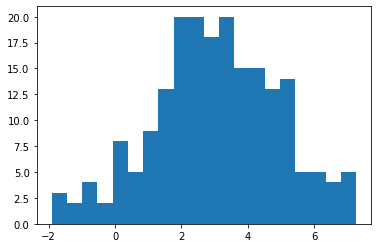

Data sample mean: 3.065080189542003
Data sample variance: 3.6152141787699223


In [17]:
# Plot a histogram of the data. Do the data look normally distributed?
plt.hist(sample_data, bins=20)
plt.show()

# Calculate the sample mean and variance of the data
print('Data sample mean:', np.mean(sample_data))
print('Data sample variance:', np.var(sample_data))

#### Generate Stan Data set and Model #### 

In [18]:
stan_data_Q2 = {
    # Data set 
    'sample_data' : sample_data, 
    'num_data' :len(sample_data),

    # Hyperparameters (Given values)
    'mu' : 0,
    'nu' : 0.054,
    'alpha' : 1.12,
    'beta' : 0.4 
}

In [29]:
stan_code_Q2 = """

data {
  int<lower = 1> num_data; 
  real sample_data[num_data];
  real<lower = 0> mu;
  real<lower = 0> nu;
  real<lower = 0> alpha; 
  real<lower = 0> beta;
}

parameters {
  real<lower = 0> x; 
  real<lower = 0> sigma2; 
}

model {
  sigma2 ~ inv_gamma(alpha, beta) ;  //Prior 
  x ~ normal(mu, sqrt(sigma2/nu)) ;

  for (i in 1:num_data) {
    sample_data[i] ~ normal(x, sqrt(sigma2)) ; //Likelihood
  }
}

"""

In [30]:
stan_model_Q2 = pystan.StanModel(model_code=stan_code_Q2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a4ff89787afd9f6a3f0e49fac98bbd9b NOW.


In [31]:
stan_results_Q2 = stan_model_Q2.sampling(data = stan_data_Q2)

In [32]:
print(stan_results_Q2.stansummary(pars = ['x', 'sigma2'], probs = [0.025, 0.975]))

Inference for Stan model: anon_model_a4ff89787afd9f6a3f0e49fac98bbd9b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
x        3.07  2.3e-3   0.13    2.8   3.32   3259    1.0
sigma2   3.62  6.7e-3   0.35    3.0   4.41   2745    1.0

Samples were drawn using NUTS at Sat Feb 20 05:09:22 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


#### Calculate posterior mean and variance with 95% Confidence Interval #### 

In [34]:
# Calculate posterior sample intervals 
posterior_samples_Q2 = stan_results_Q2.extract()
                                  
print('x: [%.3f, %.3f]' % (
    np.percentile(posterior_samples_Q2['x'], 2.5),
    np.percentile(posterior_samples_Q2['x'], 97.5)))
print('σ²: [%.3f, %.3f]' % (
    np.percentile(posterior_samples_Q2['sigma2'], 2.5),
    np.percentile(posterior_samples_Q2['sigma2'], 97.5)))

x: [2.801, 3.321]
σ²: [3.001, 4.407]


#### Plot 10 samples from the stan data with their respective mean and variance ####

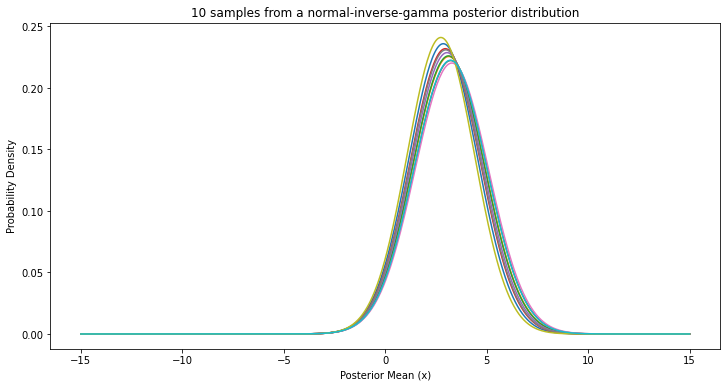

In [51]:
num_samples = 10 
samples = []

# We take x and sigma 2 samples from our stan samples 
for i in range(num_samples):
  x = np.random.choice(posterior_samples_Q2['x'], size = 1)
  y = np.random.choice(posterior_samples_Q2['sigma2'], size = 1)

  samples.append((x,y))

# We plot the our 10 chosen samples, by using normal pdf function
plot_x = np.linspace(-15,15, 500)
plt.figure(figsize=(12, 6))
plot_x = np.linspace(-15, 15, 500)
for i in range(num_samples):
    plot_y = sts.norm.pdf(plot_x, loc=samples[i][0], scale=np.sqrt(samples[i][0]))
    plt.plot(plot_x, plot_y)
plt.title('%i samples from a normal-inverse-gamma posterior distribution' % num_samples)
plt.xlabel("Posterior Mean (x)")
plt.ylabel("Probability Density")
plt.show()

### 3. Log-normal HRTEM data ###

#### Import data and show its structure ####

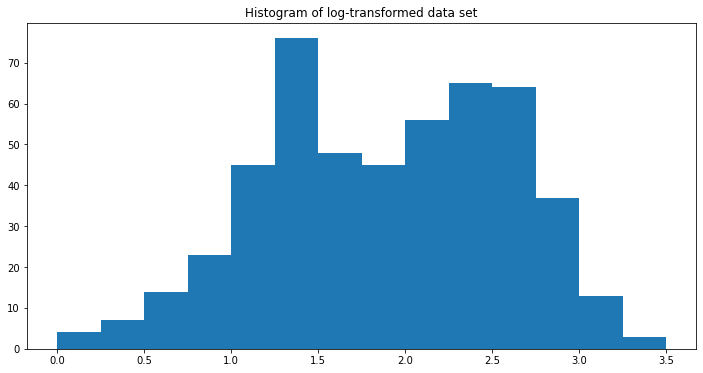

In [38]:
hrtem_df = pd.read_csv("https://course-resources.minerva.kgi.edu/uploaded_files/mke/00075398-1635/hrtem.csv", header = None)
hrtem = hrtem_df.to_numpy()

# Get the log of the hrtem data set 
log_hrtem = np.log(hrtem)


# Plot structure of log hrtem data set 
plt.figure(figsize = (12,6))
plt.hist(log_hrtem, bins = np.linspace(0,3.5,15))

plt.title("Histogram of log-transformed data set")
plt.show()


In [48]:
# Turn Numpy array to list 
log_hrtem_list = []

for num in log_hrtem:
  log_hrtem_list.append(float(num))

# Print first entry of the log data
len(log_hrtem_list)


500

#### Set Stan Data and Model ####

In [41]:
stan_data_Q3 = {
    # Data set 
    'hrtem_data' : log_hrtem_list, 
    'hrtem_num_data' :len(log_hrtem_list),

    # Hyperparameters (Given values)
    'mu' : 2.3,
    'nu' : 0.1,
    'alpha' : 2,
    'beta' : 5 
}

In [42]:
stan_code_Q3 = """

data {
  int<lower = 1> hrtem_num_data; 
  real hrtem_data[hrtem_num_data];
  real<lower = 0> mu;
  real<lower = 0> nu;
  real<lower = 0> alpha; 
  real<lower = 0> beta;
}

parameters {
  real<lower = 0> x; 
  real<lower = 0> sigma2; 
}

model {
  sigma2 ~ inv_gamma(alpha, beta) ;  //Prior 
  x ~ normal(mu, sqrt(sigma2/nu)) ;

  for (i in 1:hrtem_num_data) {
    hrtem_data[i] ~ normal(x, sqrt(sigma2)) ; //Likelihood
  }
}

"""

In [44]:
stan_model_Q3 = pystan.StanModel(model_code=stan_code_Q3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_22f4bc79f50fcca020b2352cb6c876c7 NOW.


In [45]:
stan_results_Q3 = stan_model_Q3.sampling(data = stan_data_Q3)

In [46]:
print(stan_results_Q3.stansummary(pars = ['x', 'sigma2'], probs = [0.025, 0.975]))

Inference for Stan model: anon_model_22f4bc79f50fcca020b2352cb6c876c7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
x        1.89  5.4e-4   0.03   1.83   1.95   3265    1.0
sigma2    0.5  5.4e-4   0.03   0.44   0.56   3289    1.0

Samples were drawn using NUTS at Sat Feb 20 05:29:39 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


#### Calculate 95% Confidence Interval for Mean and Variance of the HRTEM data set Posterior Results#### 

In [47]:
posterior_samples_Q3 = stan_results_Q3.extract()
                                  
print('x: [%.2f, %.2f]' % (
    np.percentile(posterior_samples_Q3['x'], 2.5),
    np.percentile(posterior_samples_Q3['x'], 97.5)))
print('σ²: [%.2f, %.2f]' % (
    np.percentile(posterior_samples_Q3['sigma2'], 2.5),
    np.percentile(posterior_samples_Q3['sigma2'], 97.5)))


x: [1.83, 1.95]
σ²: [0.44, 0.56]


#### Plot 10 samples from the Posterior HRTEM Values #### 

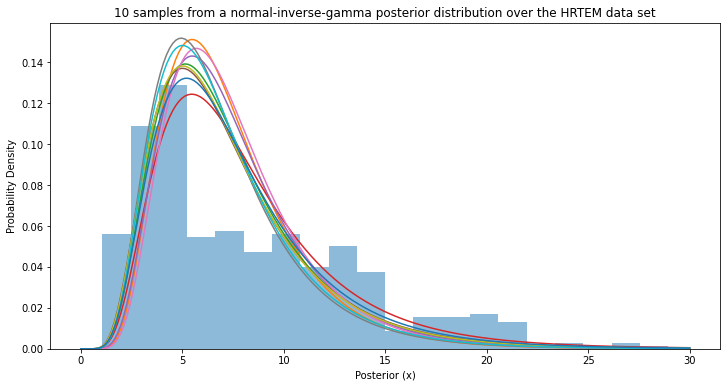

In [52]:
num_samples = 10 
samples = []

# We take x and sigma 2 samples from our stan samples 
for i in range(num_samples):
  mean = np.random.choice(posterior_samples_Q3['x'], size = 1)
  variance = np.random.choice(posterior_samples_Q3['sigma2'], size = 1)

  samples.append((mean,variance))

# We plot the our 10 chosen samples, by using normal pdf function
plt.figure(figsize=(12, 6))


plot_x = np.linspace(0,30, 200)
plt.hist(hrtem, bins = 20, density=True, alpha = 0.5)

for i in range(num_samples):
    plot_y = sts.lognorm.pdf(plot_x, samples[i][1], scale = np.exp(samples[i][0]))
    plt.plot(plot_x, plot_y)
plt.title('%i samples from a normal-inverse-gamma posterior distribution over the HRTEM data set' % num_samples)
plt.xlabel("Posterior (x)")
plt.ylabel("Probability Density")
plt.show()